<a href="https://colab.research.google.com/github/lomayka/projects/blob/master/TestTaskInt20h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: wrapt, absl-py, google-pasta, keras-preprocessing, grpcio, tensorflow-estimator, wheel, astor, termcolor, gast, six, opt-einsum, tensorboard, numpy, protobuf, keras-applications
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import gc
import sys
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [0]:
os.getcwd()

'/content'

In [0]:
!wget -x --load-cookies cookies.txt "https://www.kaggle.com/c/13032/download-all" -O 'data.zip'

--2020-01-25 16:27:14--  https://www.kaggle.com/c/13032/download-all
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13032/862545/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1580228835&Signature=NUgP5Ns05SIJSU8DuoeM0YCvMVV%2BPn5m1cEGnb2rapD4MIYkOBE8yyxH9MnVjMHYfcUqEJny0978jAJYl9KQOUDiIXwzrJLT0yj6DqN4i5zfVbjDcW0hm3mqVvtPedJW%2B75XRHd4uCMIlM5dp%2F6whYxkAvLLJkF1dJWZd9vyt20b2V0e5eYL6zBvGuQ8FeYowbANotbyKdwmQzrwxjIHFZ0HVapayrWBYFPkR6GFURaBLGQGGHY5li19lEH8GVkvq8c8Jy61ygHrnbV1H3DTp621IDLm3QClrD0nmzCcFGObxDa0hkF14XiN4Yf7KAdTb8qUz%2BFELwOrWzkmxGW1fw%3D%3D&response-content-disposition=attachment%3B+filename%3Dimaterialist-fashion-2019-FGVC6.zip [following]
--2020-01-25 16:27:15--  https://storage.googleapis.com/kaggle-competitions-data/kagg

In [0]:
os.getcwd()

'/content/input'

In [0]:
!jar -xvf '../drive/My Drive/dataset/imaterialist-fashion-2019-FGVC6.zip'

java.io.IOException: Input/output error
	at java.io.FileInputStream.readBytes(Native Method)
	at java.io.FileInputStream.read(FileInputStream.java:255)
	at java.io.BufferedInputStream.fill(BufferedInputStream.java:246)
	at java.io.BufferedInputStream.read1(BufferedInputStream.java:286)
	at java.io.BufferedInputStream.read(BufferedInputStream.java:345)
	at java.io.FilterInputStream.read(FilterInputStream.java:133)
	at java.io.PushbackInputStream.read(PushbackInputStream.java:186)
	at java.util.zip.ZipInputStream.readFully(ZipInputStream.java:403)
	at java.util.zip.ZipInputStream.readLOC(ZipInputStream.java:278)
	at java.util.zip.ZipInputStream.getNextEntry(ZipInputStream.java:122)
	at sun.tools.jar.Main.extract(Main.java:979)
	at sun.tools.jar.Main.run(Main.java:311)
	at sun.tools.jar.Main.main(Main.java:1288)


In [0]:
DATA_DIR = Path('/input')

#TO DO
# For demonstration purpose, the classification ignores attributes (only categories),
# and the image size is set to 512, which is the same as the size of submission masks
NUM_CATS = 46
IMAGE_SIZE = 512
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

In [0]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 28.37 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [0]:
!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel
os.chdir('..')

In [0]:
sys.path.append('Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
with open("input/label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

segment_df = pd.read_csv("input/train.csv")

multilabel_percent = len(segment_df[segment_df['ClassId'].str.contains('_')])/len(segment_df)*100
print(f"Segments that have attributes: {multilabel_percent:.2f}%")

Segments that have attributes: 3.47%


In [0]:
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  331213


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [0]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45195


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [0]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str('input/train/' + row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

('input/train/0de69414aef9dd6bb3815f431b1d20ab.jpg', ['shoe', 'rivet', 'pocket', 'pocket', 'buckle', 'watch', 'pants', 'shirt, blouse', 'collar', 'sleeve', 'sleeve', 'belt'])


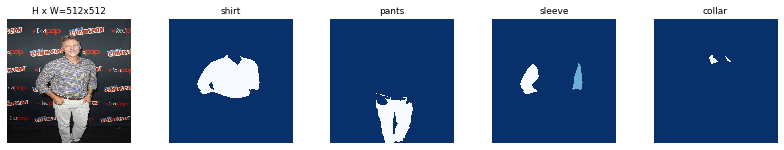

('input/train/3a2970d5e627fb6a24787aa24fb87509.jpg', ['shirt, blouse', 'collar', 'lapel', 'jacket', 'sleeve', 'pocket', 'pocket', 'pocket'])


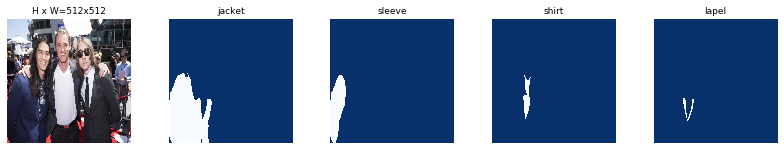

('input/train/0543934370aa87a69545d5035350036f.jpg', ['shoe', 'shoe', 'pants', 'top, t-shirt, sweatshirt', 'pocket', 'sleeve', 'sleeve', 'hood'])


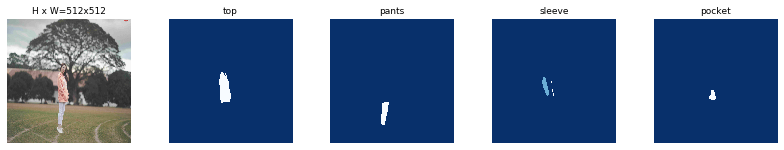

('input/train/0c038265eb1ce1d592d4a21d6b72bf43.jpg', ['top, t-shirt, sweatshirt', 'neckline', 'sleeve', 'sleeve', 'collar', 'jacket', 'zipper', 'zipper', 'watch', 'pants', 'belt', 'pocket', 'rivet', 'hat'])


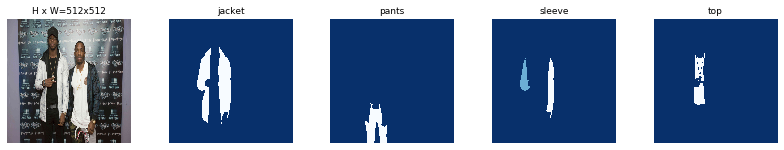

('input/train/124ad792f68a3277049a446ca95ef31e.jpg', ['top, t-shirt, sweatshirt', 'neckline', 'sleeve', 'sleeve', 'pants', 'shoe', 'shoe'])


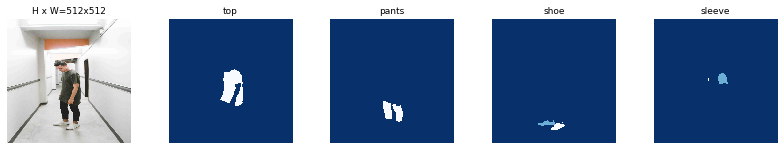

('input/train/4e6f65971aa5a718e11aef1707f5da16.jpg', ['neckline', 'sleeve', 'sleeve', 'dress', 'bag, wallet', 'sock', 'sock'])


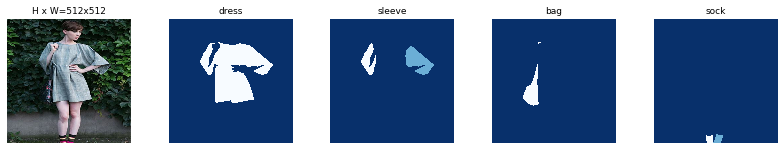

In [0]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)
    print(dataset.image_reference(image_id))
    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [0]:
#TO DO
FOLD = 0
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
splits = kf.split(image_df) # ideally, this should be multilabel stratification

def get_fold():    
    for i, (train_index, valid_index) in enumerate(splits):
        if i == FOLD:
            return image_df.iloc[train_index], image_df.iloc[valid_index]
        
train_df, valid_df = get_fold()

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [0]:
LR = 1e-4
EPOCHS = [2, 6, 8]

import warnings 
warnings.filterwarnings("ignore")

In [0]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 # a memory error occurs when IMAGES_PER_GPU is too high
    
    USE_TPU = True
    NUM_CORES = 8
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    #DETECTION_NMS_THRESHOLD = 0.0
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
config = FashionConfig()

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='Mask_RCNN')

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [0]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [0]:
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: Mask_RCNN/fashion20200125T1534/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (

ERROR:root:Error processing image {'id': 'fb2e1bdb34ace56b99befc2547a8b83d.jpg', 'source': 'fashion', 'path': 'input/train/fb2e1bdb34ace56b99befc2547a8b83d.jpg', 'labels': ['6', '4', '32', '31', '31', '35', '35', '28', '1', '33'], 'annotations': ['1421604 7 1424598 22 1427592 37 1430586 52 1430896 9 1433580 67 1433884 27 1436574 82 1436873 43 1439569 96 1439861 61 1442563 111 1442849 79 1445557 126 1445838 96 1448551 141 1448826 113 1451548 153 1451814 131 1454549 161 1454803 148 1457550 169 1457791 166 1460551 177 1460779 183 1463552 184 1463767 201 1466553 192 1466756 218 1469554 426 1472555 430 1475556 435 1478557 440 1481558 442 1484559 441 1487560 440 1490561 439 1493562 438 1496563 437 1499564 436 1502565 435 1505566 434 1508567 433 1511568 432 1514569 431 1517570 430 1520571 429 1523572 428 1526573 427 1529574 426 1532575 425 1535576 424 1538577 423 1541578 422 1544579 421 1547580 420 1550581 419 1553582 418 1556583 417 1559584 416 1562585 415 1565586 414 1568587 413 1571588 412

Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_util

In [0]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [0]:
glob_list = glob.glob(f'/kaggle/working/fashion*/mask_rcnn_fashion_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''

NameError: ignored

In [0]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='Mask_RCNN')

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [0]:
#TO DO
sample_df = pd.read_csv("input/sample_submission.csv")
sample_df.head()

In [0]:
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [0]:
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [0]:
sub_list = []
missing_count = 0
for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    image = resize_image(str('input/test'/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

In [0]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
print("Total image results: ", submission_df['ImageId'].nunique())
print("Missing Images: ", missing_count)
submission_df.head()

In [0]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str('input/test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))